In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import pingouin as pg

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import analyze2p.objects.sim_utils as su
import importlib


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

## Source

In [5]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)
#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)

ROC 0.05


#### Metadata

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


#### Trial responses

In [7]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
Stimulus: gratings (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |           883 |
| Lm |           466 |
| Li |           431 |


#### Select stimuli

In [35]:
# Select stmuli:  None, fullfield, images
select_stimuli = 'all' #'fullfield'
# -----------------------------
SDF0 = aggr.check_sdfs(NDATA0['datakey'].unique(), experiment='gratings',
                      images_only=False, rename=False, 
                      return_incorrect=False, return_all=False)
# do a quick check
dk = '20190602_JC091_fov1'
check_cfgs = aggr.select_stimulus_configs(dk, 'gratings', select_stimuli)
print(len(check_cfgs))
del dk

Checking gratings configs
64


In [36]:
correct_config_dks=[]
for dk, sdf in SDF0.groupby('datakey'):
    curr_cfgs = aggr.get_included_stimconfigs(sdf, experiment='gratings',
                                        select_stimuli=select_stimuli)
    if len(curr_cfgs)>0:
        correct_config_dks.append(dk)
SDF = SDF0[SDF0.datakey.isin(correct_config_dks)].copy()

In [37]:
len(SDF['datakey'].unique()), len(SDF0['datakey'].unique())

(19, 19)

In [33]:
SDF0 = aggr.check_sdfs(NDATA0['datakey'].unique(), experiment='gratings',
                      images_only=False, rename=False, 
                      return_incorrect=False, return_all=True)
for dk, sdf in SDF0.groupby('datakey'):
    sf = sdf['sf'].unique()
    sp = sdf['speed'].unique()
    sz = sdf['size'].unique()
    print('%s: sf=%s, sz=%s, sp=%s' % (dk, str(sf), str(sz), str(sp)) )

Checking gratings configs
20190306_JC061_fov2: sf=[0.1], sz=[60.0], sp=[10]
20190314_JC070_fov1: sf=[0.1], sz=[60.0], sp=[10]
20190315_JC070_fov2: sf=[0.1], sz=[60.0], sp=[10]
20190319_JC067_fov1: sf=[0.1], sz=[60.0], sp=[10]
20190321_JC070_fov2: sf=[0.1], sz=[60.0], sp=[10]
20190511_JC083_fov1: sf=[0.1 0.5], sz=[200.0 20.0 40.0], sp=[20]
20190512_JC083_fov1: sf=[0.1 0.5], sz=[200.0 30.0 60.0], sp=[20]
20190513_JC078_fov1: sf=[0.1 0.5], sz=[200.0 30.0], sp=[20 10]
20190517_JC083_fov1: sf=[0.1 0.5], sz=[200.0 30.0], sp=[20 10]
20190522_JC084_fov1: sf=[0.1 0.5], sz=[20.0 200.0], sp=[10 20]
20190522_JC089_fov1: sf=[0.1 0.5], sz=[200.0], sp=[10 20]
20190525_JC084_fov1: sf=[0.1 0.5], sz=[30.0 200.0], sp=[10 20]
20190527_JC092_fov3: sf=[0.1 0.5], sz=[200.0], sp=[10]
20190602_JC091_fov1: sf=[0.1 0.5], sz=[30.0 200.0], sp=[10 20]
20190603_JC080_fov1: sf=[0.1 0.5], sz=[30.0 200.0], sp=[10 20]
20190606_JC091_fov1: sf=[0.1 0.5], sz=[30.0 200.0], sp=[10 20]
20190607_JC091_fov1: sf=[0.1 0.5], sz=[3

#### Tuning curve fits

In [38]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)
#### Only take good fits
if select_stimuli=='fullfield':
    currg = gdata[(gdata['size']==200)].copy()#.reset_index(drop=True)
elif select_stimuli in ['apertured', 'images']:
    currg = gdata[(gdata['size']<200)].copy()#.reset_index(drop=True)
else: # all conds
    currg = gdata.copy()
# One stim config per cell
best_gof_ixs = currg.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == currg['gof']
assert currg.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = currg.loc[best_gof_ixs].copy()

#### Drop repeats

In [39]:
# Unique datasets, get dsets with most ncells pass
min_ncells=5
gof_thr=0.5
drop_repeats=True
# -------------------------------------------
counts0 = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
# Get unique dkeys based on # cells fit
counts_fit = counts0[(counts0.n_cells>=min_ncells)]
u_dkeys = aggr.drop_repeats(counts_fit, colname='n_cells') 
# Drop duplicates
FITS = pd.concat([g for (va, dk), g \
                in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])
FITS['response_diff'] = FITS['response_pref'] - FITS['response_null']
# count N fits
ncells_fit = aggr.count_n_cells(FITS)
ncells_fit.groupby('visual_area').sum()
print("FIT totals (pass, GoF>%.2f)" % gof_thr)
print(ncells_fit.groupby('visual_area').sum().to_markdown())
# Drop repeat FOVs for trial metrics
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and dk in SDF['datakey'].unique()], 
                  ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
ncells_responsive = aggr.count_n_cells(NDATA)
count_responsive = aggr.get_final_cell_and_site_counts(ncells_responsive)
print("RESPONSIVE totals: %s (%s)" % (experiment, responsive_test))
print(count_responsive.to_markdown())

FIT totals (pass, GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        50 |
| Lm            |       214 |
| V1            |       444 |
RESPONSIVE totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       193 |         4 |
| Lm            |       201 |         4 |
| V1            |       764 |         6 |


#### Load RFs

In [40]:
# Load RF data
response_type='dff'
do_spherical_correction=False
# ---------------------------------------------------------------------
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(CELLS, sdata, response_type=response_type,
                       do_spherical_correction=do_spherical_correction,
                        reliable_only=False, pass_criterion='position', 
                        combine='average')
print(rfdf['experiment'].unique())
rfdf['rf_theta_deg'] = [np.rad2deg(i) % 180 for i in rfdf['theta_Mm_c'].values]
rfdf = aggr.add_roi_positions(rfdf.copy())
# print stuff
rf_counts = aggr.count_n_cells(rfdf)
rf_counts.groupby('visual_area').sum()
# Load RF polys
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
['average_rfs']


#### Counts

In [41]:
FITS_counts = aggr.count_n_cells(FITS)
FITS_counts.groupby('visual_area').sum()

,n_cells
visual_area,
Li,50
Lm,214
V1,444


In [42]:
fits_rfs = pd.merge(FITS, rfdf, on=['visual_area', 'datakey', 'cell'], how='left')
fits_rfs.shape, FITS.shape

((708, 61), (708, 24))

## Output dirs

In [43]:
data_id = '|'.join([traceid, ori_fit_desc, rf_str])
print(data_id)

#### Set current output dir
base_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test))
print(base_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'correlations')
print(FIGDIR)

traces001|fit-dff_responsive-ROC-thr0.05_boot-500|rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlations


In [45]:
print(select_stimuli)
# ----------------------------------------
# Results outfile
stim_str = '%s-%s' % (responsive_test, select_stimuli)
print(stim_str)
print(rf_str)
dists_results_file = os.path.join(base_dir, 'results_%s_%s.pkl' % (stim_str, rf_str))
print(dists_results_file)

# Figure save dir
dst_dir = os.path.join(base_dir, '%s_%s' % (stim_str, rf_str))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)


all
ROC-all
rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/results_ROC-all_rfs-dff-uncorr.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr


# FITS:  check metrics of current subset

<IPython.core.display.Javascript object>


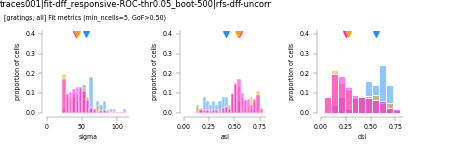

No handles with labels found to put in legend.


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr fitparams_hist_all
sigma------------------------
             count   mean    std    min    25%    50%    75%     max
visual_area                                                         
Li            50.0  57.48  18.13  24.73  47.08  55.52  64.56  112.84
Lm           214.0  44.40  17.30  22.50  29.95  43.43  54.42  103.38
V1           444.0  42.85  14.98  22.50  31.66  42.36  51.30  110.93
asi------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            50.0  0.40  0.15  0.15  0.28  0.42  0.51  0.71
Lm           214.0  0.54  0.15  0.09  0.49  0.54  0.66  0.78
V1           444.0  0.55  0.13  0.14  0.50  0.55  0.63  0.77
dsi------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            50.0  0.50

In [47]:
%matplotlib notebook
means_= FITS.groupby('visual_area').median()

plot_params = [ 'sigma', 'asi', 'dsi' ]
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))

ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=FITS, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_box_aspect(1)
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.9, wspace=0.6)
sns.despine(offset=4)
fig.text(0.01, 0.87, '[%s, %s] Fit metrics (min_ncells=%i, GoF>%.2f)'\
         % (experiment, select_stimuli, min_ncells, gof_thr))

pplot.label_figure(fig, data_id)
figname = 'fitparams_hist_%s' % select_stimuli
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
for param in plot_params:
    print('%s------------------------' % param)
    print(FITS.groupby(['visual_area'])[param].describe().round(2))

<IPython.core.display.Javascript object>


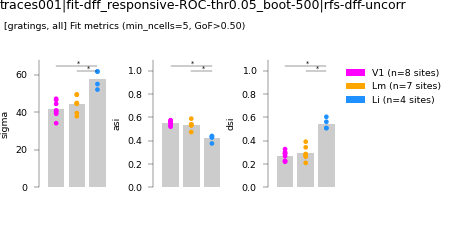

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr fitparams_byFOV_all
sigma------------------------
             count   mean    std    min    25%    50%    75%     max
visual_area                                                         
Li            50.0  57.48  18.13  24.73  47.08  55.52  64.56  112.84
Lm           214.0  44.40  17.30  22.50  29.95  43.43  54.42  103.38
V1           444.0  42.85  14.98  22.50  31.66  42.36  51.30  110.93
asi------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            50.0  0.40  0.15  0.15  0.28  0.42  0.51  0.71
Lm           214.0  0.54  0.15  0.09  0.49  0.54  0.66  0.78
V1           444.0  0.55  0.13  0.14  0.50  0.55  0.63  0.77
dsi------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li            50.0  0.5

In [64]:
# Plot PER FOV averages
%matplotlib notebook
plot_params = ['sigma', 'asi', 'dsi']
fov_meds = FITS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn = pl.subplots(1,len(plot_params), figsize=(4,2),dpi=150)
y_loc=0.7
for ax, par in zip(axn.flat, plot_params):
    y_loc=np.ceil(fov_meds[par].max())
    offset = y_loc/25
    pplot.stripplot_metric_by_area(fov_meds, ax=ax, metric=par,markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
    ax.set_xticklabels('')
va_labels = dict((va, '%s (n=%i sites)' % (va, len(g['datakey'].unique()))) \
             for va, g in fov_meds.groupby('visual_area'))
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=[va_labels[v] for v in visual_areas],
                                   linestyles='', use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
          frameon=False, markerscale=0.25, fontsize=6)
pplot.adjust_subplots(bottom=0.1, right=0.75, wspace=0.8)
sns.despine(offset=4, bottom=True)

fig.text(0.01, 0.87, '[%s, %s] Fit metrics (min_ncells=%i, GoF>%.2f)'\
         % (experiment, select_stimuli, min_ncells, gof_thr))

pplot.label_figure(fig, data_id)
figname = 'fitparams_byFOV_%s' % select_stimuli
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
for param in plot_params:
    print('%s------------------------' % param)
    print(FITS.groupby(['visual_area'])[param].describe().round(2))
    

# CORRS:  signal_cc and noise_cc

In [68]:
print(select_stimuli)
min_ncells=5
CORRS = cr.aggregate_ccdist(NDATA, experiment='gratings', #rfdf=rfdf, #rfpolys=rfpolys,
                        SDF=SDF, select_stimuli=select_stimuli, min_ncells=min_ncells,
                        verbose=True)

all
Dist: cortical_distance
Li 20190602_JC091_fov1 gratings
Li 20190609_JC099_fov1 gratings
Li 20190614_JC091_fov1 gratings
Li 20191111_JC120_fov1 gratings
Lm 20190525_JC084_fov1 gratings
Lm 20190603_JC080_fov1 gratings
Lm 20190618_JC097_fov1 gratings
Lm 20190627_JC091_fov1 gratings
V1 20190522_JC084_fov1 gratings
V1 20190613_JC097_fov1 gratings
V1 20190616_JC097_fov1 gratings
V1 20190617_JC097_fov1 gratings
V1 20190622_JC085_fov1 gratings
V1 20191006_JC110_fov1 gratings
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [70]:
print(CORRS.shape)

(63656, 10)


#### Average signal and noise correlation values by FOV

<IPython.core.display.Javascript object>


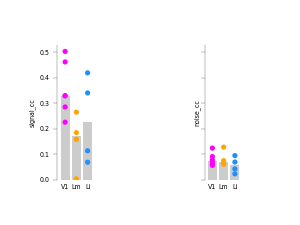

In [91]:
corrs_fov = CORRS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn =pl.subplots(1, 2, figsize=(4,3), sharey=True)
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    pplot.stripplot_metric_by_area(corrs_fov, metric=metric, ax=ax,
            markersize=5,area_colors=area_colors,mean_style='bar', posthoc='fdr_by',
            y_loc=0.3, jitter=False)


<IPython.core.display.Javascript object>


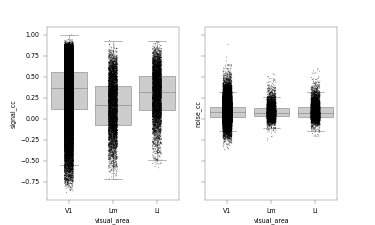

<IPython.core.display.Javascript object>


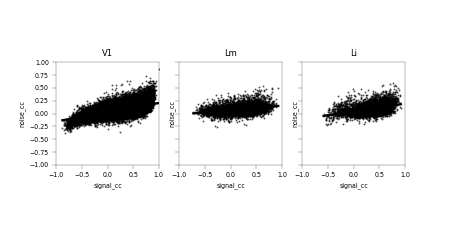

In [160]:

fig, axn =pl.subplots(1, 2, figsize=(5,3), sharey=True)
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    sns.boxplot(x='visual_area', y=metric, data=CORRS, ax=ax,
                fliersize=0,linewidth=0.5, order=visual_areas, color=[0.8]*3)
    sns.stripplot(x='visual_area', y=metric, data=CORRS, s=1, ax=ax,
                  alpha=0.5, color='k', order=visual_areas)

fig, axn =pl.subplots(1, 3, figsize=(6,3), sharey=True)
df = CORRS.dropna()
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.regplot(x='signal_cc', y='noise_cc', data=vg, ax=ax,
                        scatter_kws=scatter_kws, color='k')
    ax.set_box_aspect(1)
    ax.set_title(va)
    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_aspect('equal')
    

#### Distance as a function of signal/noise cc

<IPython.core.display.Javascript object>


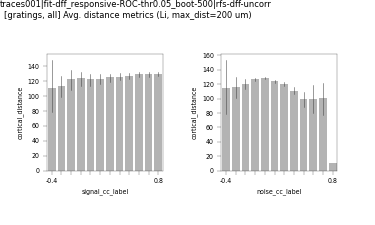

In [126]:
%matplotlib notebook
ctx_maxdist = 200
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# ------------------------------------------------------------
metric_vars = ['signal_cc', 'noise_cc']
y_var = 'cortical_distance'
fig, axn =pl.subplots(1, 2,figsize=(5,3), dpi=100, sharex=True)
for ri, x_var in enumerate(metric_vars):
    #x_bins = dist_lut[dist_var]['bins']
    x_bins = sorted(df['%s_label' % x_var].unique())
    xticks=np.arange(0, len(x_bins))
    ax=axn[ri]
    sns.barplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
                color=[0.7]*3, errwidth=0.5)
#     sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
#                   s=1, alpha=0.5, color='k')
    ax.set_xticks(xticks)
    ax.set_xticklabels([round(x_bins[i], 1) if i==xticks[0]\
                        or i==xticks[-1] else ''
                       for i in xticks])
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.5, hspace=0.7, top=0.8)
fig.text(0.01, 0.92, '[%s, %s] Avg. distance metrics (%s, max_dist=%i um)' 
         % (experiment, select_stimuli, va, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)

In [134]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr'

#### Binned distance, compare SIGNAL_CC (and shuffle)

<IPython.core.display.Javascript object>


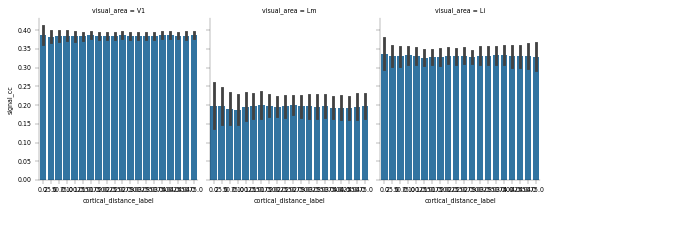

In [127]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# Shuffle
combined_ = cr.shuffle_bins_by_area(df, dist_var=dist_var, n_iterations=100)

# Plot shuffled to check
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   data=combined_[combined_.condition=='shuffled'])
fg.map(sns.barplot, '%s_label' % dist_var, 'signal_cc' , ci='sd')
pl.subplots_adjust(bottom=0.2, right=0.8)

100.0


<IPython.core.display.Javascript object>


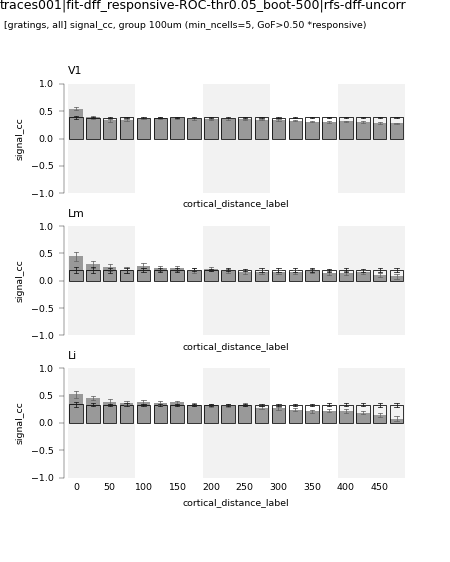

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr binned-dist-bar_signal_cc_v_cortical_distance_responsive_max500


In [135]:
dist_unit='um'
curr_maxdist = dist_lut[dist_var]['max_dist']
plot_pairs=False
# curr_maxdist=60 if dist_var=='rf_distance' else 500
plot_str = '_wpairs' if plot_pairs else ''
sorted_x_vars =  dist_lut[dist_var]['bins']
bin_width = 4 if dist_var=='cortical_distance' else 5
patch_step = sorted_x_vars[bin_width] #+dist_lut[dist_var]['step']
print(patch_step)
%matplotlib notebook
fig = cr.barplot_with_shuffled_distbins(combined_, dist_var, y_var,
                     curr_maxdist=curr_maxdist, round_x=0, dist_unit=dist_unit,
                     barcolor=[0.6]*3, errcolor=[0.4]*3, errcolor_shuffled=[0.1]*3,
                     plot_pairs=plot_pairs,figsize=(4,5),
                     draw_group_patch=True, bin_width=bin_width)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.85, hspace=0.3)
fig.text(0.01, 0.95, "[%s, %s] %s, group %i%s (min_ncells=%i, GoF>%.2f *%s)" \
         % (experiment, select_stimuli, y_var, \
            patch_step, dist_unit, min_ncells, gof_thr, tuned_or_resp))

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_%s_max%i%s' \
            % (y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

signal_cc cortical_distance
NEAR: [0.0, 25.0, 50.0, 75.0]
FAR: [100.0, 125.0, 150.0, 175.0]
4298 9203


<IPython.core.display.Javascript object>


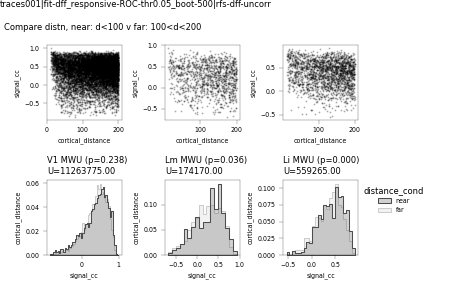

In [133]:
plotd = combined_[(combined_.condition=='data') & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = 100
upper_lim = 200
near_bins = [b for b in dist_lut[dist_var]['bins'] if b<near_lim]
far_bins = [b for b in dist_lut[dist_var]['bins'] \
           if (b>=near_lim) and (b<upper_lim)]
print("NEAR:", near_bins)
print("FAR:", far_bins)

#near_bins = [0,2] if dist_var=='rf_distance' else [0, 25, 50, 75]
# far_bins = [4, 6] if dist_var=='rf_distance' else [100, 125, 150, 175]
# near_bins = [0,2] if dist_var=='rf_distance' else [0, 25]
# far_bins = [4, 6] if dist_var=='rf_distance' else [50, 75]

col1=[0.3]*3
col2=[0.8]*3
curr_dist_colors = dict((k, v) for k, v in zip(['near', 'far'], [col1, col2]))

v1df = plotd[plotd['%s_label' % dist_var].isin(near_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var]].copy()
v2df = plotd[plotd['%s_label' % dist_var].isin(far_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var]].copy()
print(len(v1df), len(v2df))
v1df['distance_cond'] = 'near'
v2df['distance_cond'] = 'far'
dist_df = pd.concat([v1df, v2df], axis=0, ignore_index=True)

fig, axn = pl.subplots(2, 3, sharex=False, sharey=False, figsize=(6,4))

for va, vg in dist_df.groupby('visual_area'):
    ax=axn[0, visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=vg, s=1, color='k', alpha=0.2)
    ax.set_xlabel(dist_var)
    ax.set_ylabel(y_var)
    
    ax=axn[1, visual_areas.index(va)]
    sns.histplot(x=y_var, data=vg, hue='distance_cond', ax=ax,
                 palette=curr_dist_colors, cumulative=False, common_norm=False,
                stat='probability', element='step', lw=1)
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left',
                  frameon=False)
    else:
        ax.legend_.remove()
    v1 = vg[vg.distance_cond=='near'][y_var].values
    v2 = vg[vg.distance_cond=='far'][y_var].values
    U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
    ax.set_ylabel(dist_var)
    ax.set_title('%s MWU (p=%.3f)\nU=%.2f' % (va, p, U), loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.8, bottom=0.15, top=0.85, 
                   hspace=0.8)
fig.text(0.01, 0.9, 'Compare distn, near: d<%i v far: %i<d<%i' \
             % (near_lim, near_lim, upper_lim), fontsize=8)
pplot.label_figure(fig, data_id)

# DISTS:  Correlate tuning curves

In [231]:
import _pickle as pkl
import copy

In [137]:
create_new=False
if not create_new:
    try:
        with open(dists_results_file, 'rb') as f:
            res = pkl.load(f)
        DISTS = res['DISTS']
        del res
    except Exception as e:
        create_new=True
print("new? %s" % str(create_new))

new? False


In [138]:
FITS['experiment'] = 'gratings'
curr_fits = FITS[(FITS.gof>0.5)].copy() # & (FITS.dsi>=0.3)].copy()
count_strong = aggr.count_n_cells(curr_fits)
count_strong.groupby('visual_area').sum()

,n_cells
visual_area,
Li,50
Lm,214
V1,444


In [139]:
# create_new=True

In [140]:
if create_new:
    print("Creatnig new DISTS. Saving to:\n    %s" % dists_results_file)
    DISTS = cr.aggregate_tuning_curve_ccdist(curr_fits, rfdf=rfdf, rfpolys=rfpolys, 
                                         min_ncells=5)
    res = {'DISTS': DISTS}
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

In [141]:
DISTS.shape

(35737, 27)

In [142]:
print(select_stimuli)

all


# MERGE DISTS and CORRS

In [143]:
DISTS = DISTS.rename(columns={'n_cells':'n_cells_fit'})
CORRS = CORRS.rename(columns={'n_cells':'n_cells_responsive'})
incl_cc_cols = ['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
               'visual_area', 'datakey', 'n_cells_responsive']

In [144]:
ccdist = pd.merge(CORRS[incl_cc_cols], DISTS,
            on=['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2'], 
            how='outer', suffixes=('_fit', '_responsive'))
ccdist.shape, CORRS.shape, DISTS.shape

((69641, 30), (63656, 10), (35737, 27))

#### Check merge

In [145]:
check_pairs=[]; checkdf=None;
for (va, dk), g in ccdist.groupby(['visual_area', 'datakey']):
    curr_pairs = g['neuron_pair'].values
    cc = CORRS[(CORRS.visual_area==va) & (CORRS.datakey==dk)]
    not_in_cc = [k for k in curr_pairs if k not in cc['neuron_pair'].values]
    if len(not_in_cc)>0:
        check_pairs.append(g[g['neuron_pair'].isin(not_in_cc)])
if len(check_pairs)>0:
    checkdf = pd.concat(check_pairs, axis=0, ignore_index=True)
else:
    print("No extra pairs found.")

In [146]:
if checkdf is not None:
    for (va, dk), g in checkdf.groupby(['visual_area', 'datakey']):
        found_cc = CORRS[(CORRS.visual_area==va) & (CORRS.datakey==dk)]
        assert len(found_cc)==0, "Oh, actually found cc.. (%s, %s)" % (va, dk)
        sdf = SDF[(SDF.datakey==dk)]
        assert len(sdf)==0, '... and also had the correct configs? (%s, %s)' % (va, dk)

## SIGNAL v RF distances -- check V1

<IPython.core.display.Javascript object>


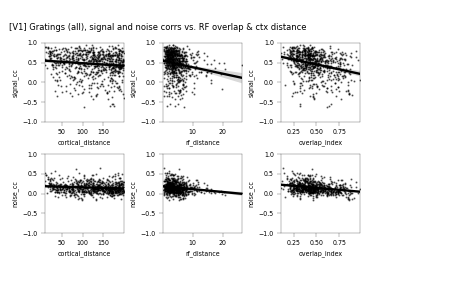

Text(0.02, 0.9, '[V1] Gratings (all), signal and noise corrs vs. RF overlap & ctx distance')

In [147]:
va='V1'
ctx_maxdist=200
scatter_kws={'s':1, 'alpha':0.5, 'color':'k'}

metric='noise_cc'
dist_vars=['cortical_distance','rf_distance', 'overlap_index']

df = ccdist[(ccdist.visual_area==va) 
           & (ccdist.cortical_distance<=ctx_maxdist)].copy().dropna()
fig, axn =pl.subplots(2, 3, figsize=(6,4))
for ri, metric in enumerate(['signal_cc', 'noise_cc']):
    for ci, dist_var in enumerate(dist_vars):
        ax=axn[ri, ci]
        sns.regplot(x=dist_var, y=metric, data=df, ax=ax,
                    scatter_kws=scatter_kws, color='k')
        pl.subplots_adjust(bottom=0.2, right=0.8)
        ax.set_ylim([-1, 1])
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.5)
fig.text(0.02, 0.9, \
    '[%s] Gratings (%s), signal and noise corrs vs. RF overlap & ctx distance' \
         % (va, select_stimuli), fontsize=8)

#### Average DIST vs. binned metric

In [161]:
ctx_maxdist = 200
va='V1'
df = ccdist[(ccdist.cortical_distance<=ctx_maxdist)
          & (ccdist.visual_area==va)].copy() #.dropna()

df, dist_lut = cr.get_bins_and_cut(df, cc_step=0.2,
                            ori_step=15, dir_step=30, ctx_step=50, rf_step=5)

<IPython.core.display.Javascript object>


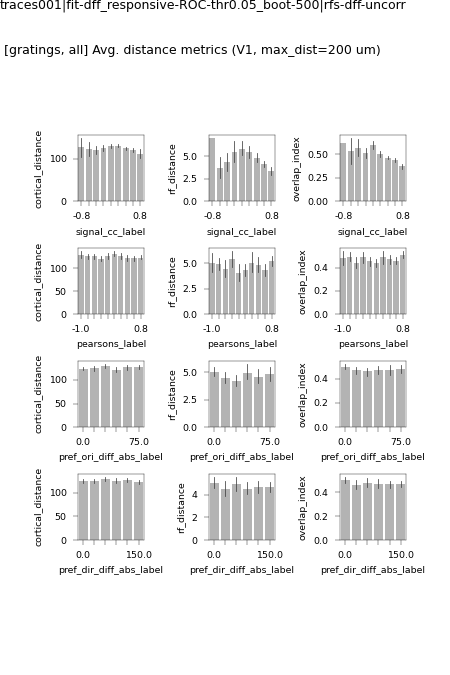

In [165]:
metric_vars = ['signal_cc', 'pearsons', 'pref_ori_diff_abs', 'pref_dir_diff_abs']
dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']
fig, axn =pl.subplots(len(metric_vars), len(dist_vars),figsize=(4,6), dpi=150)
for ri, x_var in enumerate(metric_vars):
    x_bins = sorted(df['%s_label' % x_var].dropna().unique())
    xticks=np.arange(0, len(x_bins))
    for ci, y_var in enumerate(dist_vars):
        ax=axn[ri, ci]
        sns.barplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
                    color=[0.7]*3, errwidth=0.5)
        ax.set_xticks(xticks)
        ax.set_xticklabels([round(x_bins[i], 1) if i==xticks[0]\
                            or i==xticks[-1] else ''
                           for i in xticks])
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.95, wspace=0.2, hspace=0.7, top=0.8)
fig.text(0.01, 0.92, '[%s, %s] Avg. distance metrics (%s, max_dist=%i um)' 
         % (experiment, select_stimuli, va, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)

## signal_cc vs. pref_dir

<IPython.core.display.Javascript object>


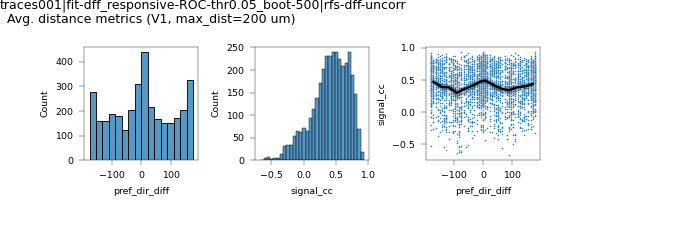

In [166]:
va='V1'
vg = ccdist[ccdist.visual_area==va].copy().dropna()
fig, axn = pl.subplots(1, 3, figsize=(6,2), dpi=150)
ax=axn[0]
sns.histplot(x='pref_dir_diff', data=vg, ax=ax)
ax=axn[1]
sns.histplot(x='signal_cc', data=vg, ax=ax)
ax=axn[2]
sns.scatterplot(x='pref_dir_diff', y='signal_cc', ax=ax, data=vg, s=1)
# curr_bins = np.linspace(-180, 180, 45)
bin_var='pref_dir_diff'
curr_bins = np.linspace(-180, 180, 15)
vg = cr.cut_bins(vg, curr_bins, bin_var, include_lowest=True)
sns.lineplot(x='%s_value' % bin_var, y='signal_cc', ax=ax, data=vg,
                color='k')
for ax in axn:
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.8,  wspace=0.5)
fig.text(0.01, 0.9, 'Avg. distance metrics (%s, max_dist=%i um)' 
         % (va, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)


## Medians by FOV (bar plot)

<IPython.core.display.Javascript object>


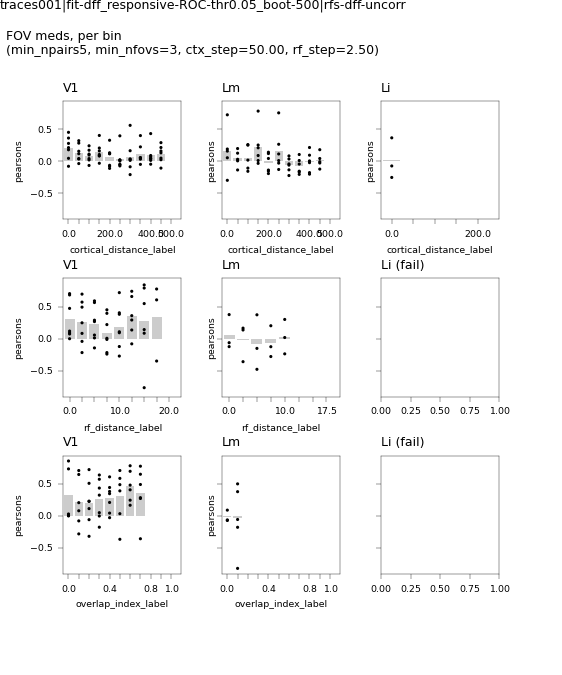

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr barplot_pearsons_v_dist-metrics


In [230]:
%matplotlib notebook
metric = 'pearsons'

ctx_maxdist=500
min_nfovs=3
min_npairs=5

ctx_step = 50
rf_step=2.5
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=ctx_step, rf_step=rf_step, 
                                   overlap_step=0.1, equal_bins=False)
dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']

%matplotlib notebook
fig = cr.barplot_fov_medians_per_bin(metric, dist_vars, df, dist_lut, 
                min_npairs=min_npairs, min_nfovs=min_nfovs, round_x=1,
                xtick_step=4, sharex_dist=False, barcolor=[0.8]*3, strip_size=2,
                figsize=(5,6))
                             
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, top=0.85)
fig.text(0.01, 0.92, \
        'FOV meds, per bin\n(min_npairs%i, min_nfovs=%i, ctx_step=%.2f, rf_step=%.2f)'\
         % (min_npairs, min_nfovs, ctx_step, rf_step), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'barplot_%s_v_dist-metrics' % (metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Heatmaps: cortical vs. RF distance

In [233]:
# Split distances into X um bins
x_var = 'cortical_distance'
y_var = 'overlap_index'
hue_var = 'pearsons'
# -----------------------------
ctx_maxdist = 500 #500
rf_maxdist=50
if hue_var == 'signal_cc':
    df, dist_lut = cr.get_bins_and_cut(ccdist[(ccdist.cortical_distance<=ctx_maxdist)
                                        & (ccdist.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
else:
    df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                                        & (DISTS.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
    
print(df.groupby([x_var, y_var])[hue_var].mean().min())
print(df.groupby([x_var, y_var])[hue_var].mean().max())

-0.977253618038639
0.9999278902370032


<IPython.core.display.Javascript object>


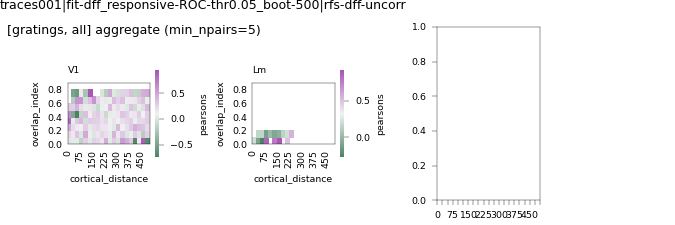

Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/ROC-all_rfs-dff-uncorr heatmaps_aggrFOV_overlap_index_v_cortical_distance_hue-pearsons


In [236]:
# x_var = 'cortical_distance'
# y_var = 'overlap_index'
# hue_var = 'pearsons_morph'
# -----------------------------
min_npairs=5
x_bins = dist_lut[x_var]['bins']
y_bins = dist_lut[y_var]['bins']
hue_min, hue_max = None, None #@(-1, 1)
#hue_min, hue_max =  (-0.2, 0.5) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
#hue_min, hue_max =  (-0.3, 0.8)

cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=False)
# cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=min_npairs][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=min_npairs][y_var_name].unique()
    df0 = vg[(vg[x_var_name].isin(valid_x)) & (vg[y_var_name].isin(valid_y))]
    if len(df0)==0:
        print(va)
        continue
    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=True, cbar_kws={'shrink':0.5})
#                                       cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    yticks = np.arange(0, len(y_bins))
    curr_ylim = df0.dropna()[y_var_name].max()
    ax.set_ylim([0, list(y_bins).index(curr_ylim)])
    ax.set_ylabel(y_var)
    ax.set_xlabel(x_var)
    # ax.invert_yaxis()
fig.text(0.01, 0.85, '[%s, %s] aggregate (min_npairs=%i)' 
         % (experiment, select_stimuli, min_npairs), fontsize=8)
pl.subplots_adjust(wspace=0.8, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'heatmaps_aggrFOV_%s_v_%s_hue-%s' % (y_var, x_var, hue_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [227]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [168]:
select_stimuli

'all'

#### DIR-tuned

In [381]:
ctx_maxdist = 500
df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)], 
                                dir_step=30, ori_step=30, cc_step=0.2, ctx_step=25)             

In [384]:
dist_lut['rf_distance']

{'bins': array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
        27.5, 30. , 32.5, 35. , 37.5]),
 'step': 2.5,
 'max_dist': 36.0}

<IPython.core.display.Javascript object>


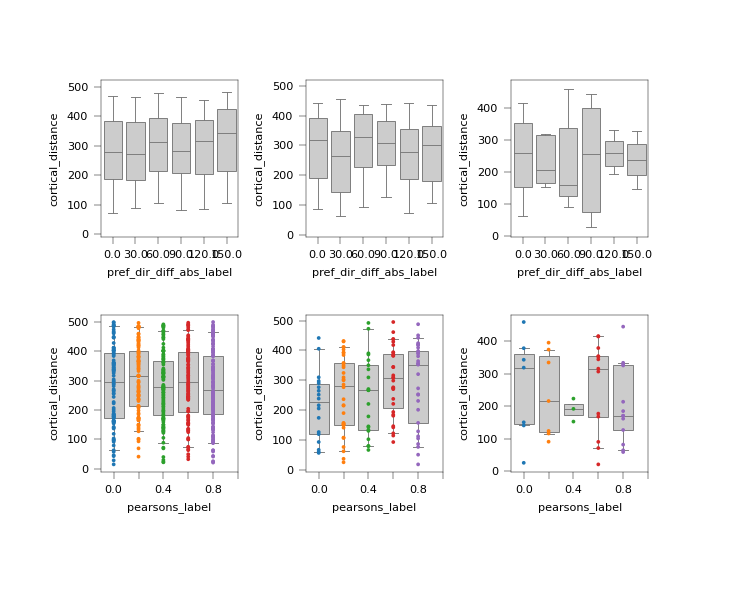

In [394]:
%matplotlib notebook
fig, axn =pl.subplots(2, 3, figsize=(6,5), dpi=150)

for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[0, vi]
    x_var = 'pref_dir_diff_abs'
    y_var = 'cortical_distance'
    sns.boxplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
               fliersize=0, color=[0.8]*3, linewidth=0.5)
#     sns.stripplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, size=2,
#                   jitter=False)
    ax=axn[1, vi]
    x_var = 'pearsons'
    y_var = 'cortical_distance'
    sns.boxplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
               fliersize=0, color=[0.8]*3, linewidth=0.5)
    sns.stripplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, size=2,
                  jitter=False)
    xbins = dist_lut[x_var]['bins']
    xticks = np.arange(0, len(xbins))
    ax.set_xticks(xticks)
    ax.set_xticklabels([round(xbins[i], 1) if i%2==0 else ''
                       for i in xticks])

pl.subplots_adjust(bottom=0.3, right=0.8, wspace=0.5, hspace=0.5)

In [390]:
xbins

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

<IPython.core.display.Javascript object>


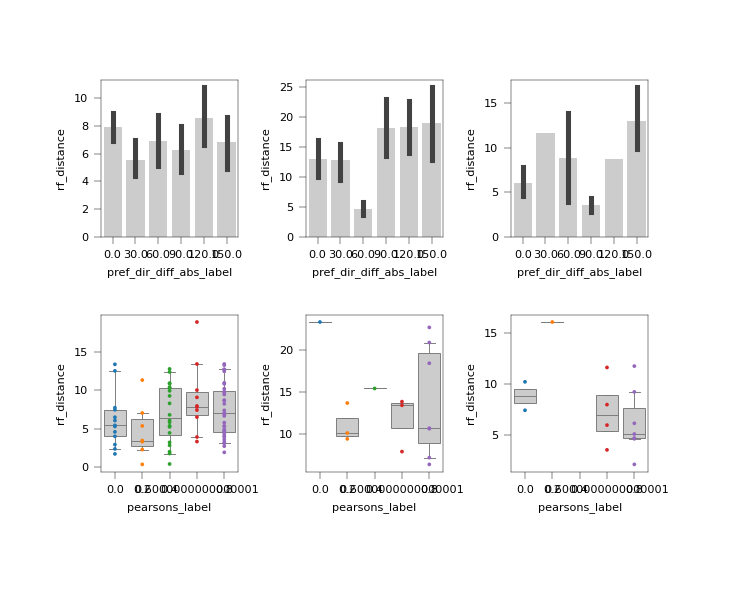

In [383]:
%matplotlib notebook
fig, axn =pl.subplots(2, 3, figsize=(6,5), dpi=150)

for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[0, vi]
    x_var = 'pref_dir_diff_abs'
    y_var = 'rf_distance'
    sns.barplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax,
               color=[0.8]*3, linewidth=0.5)
#     sns.boxplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
#                fliersize=0, color=[0.8]*3, linewidth=0.5)
#     sns.stripplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, size=2,
#                   jitter=False)
    ax=axn[1, vi]
    x_var = 'pearsons'
    y_var = 'rf_distance'
    sns.boxplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
               fliersize=0, color=[0.8]*3, linewidth=0.5)
    sns.stripplot(x='%s_label' % x_var, y=y_var, data=vg, ax=ax, size=2,
                  jitter=False)

pl.subplots_adjust(bottom=0.3, right=0.8, wspace=0.5, hspace=0.5)

#### vs overlap index (has RFs)

In [319]:
ctx_maxdist = 200
va='V1'
df = simcc[(simcc.cortical_distance<=ctx_maxdist)
          & (simcc.visual_area==va)].copy().dropna()
df, dist_lut = cr.get_bins_and_cut(df, dir_step=30, ori_step=15)

<IPython.core.display.Javascript object>


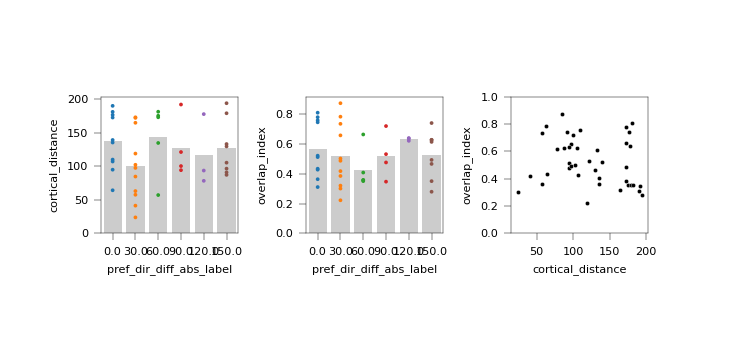

In [320]:
fig, axn =pl.subplots(1,3,figsize=(6,3), dpi=150)
ax=axn[0]
x_var = 'pref_dir_diff_abs'
y_var = 'cortical_distance'
sns.barplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, ci=None, color=[0.8]*3)
sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, size=2,
              jitter=False)

ax=axn[1]
x_var = 'pref_dir_diff_abs'
y_var = 'overlap_index'
sns.barplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, ci=None, color=[0.8]*3)
sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, size=2,
              jitter=False)
ax=axn[2]
x_var = 'cortical_distance'
y_var = 'overlap_index'
sns.scatterplot(x=x_var, y=y_var, data=df, ax=ax, s=5, color='k')
ax.set_ylim([0, 1])
for ax in axn.flat:
    ax.set_box_aspect(1)
    
pl.subplots_adjust(bottom=0.3, right=0.8, wspace=0.5)

In [95]:
neg_corrs = DISTS[DISTS.pearsons<-0.8].copy()
n_ = []
for dk, nc in neg_corrs[(neg_corrs['visual_area']=='V1')].groupby('datakey'):
    check_cells = np.union1d(nc['cell_1'].unique(), nc['cell_2'].unique())
    fits_ = FITS[(FITS.visual_area=='V1') & (FITS.datakey==dk)
                & (FITS['cell'].isin(check_cells))].copy()
    fits_.index = fits_['cell'].values
    resp = fits_[(fits_['response_pref']>0.2) 
                 & (fits_.gof>=0.66) & (fits_.response_diff>0.01)]
    print("%s: %i of %i responsive" % (dk, len(resp), len(fits_)))
    n_.append(fits_)
neg_and_strong = pd.concat(n_, axis=0)

20190511_JC083_fov1: 15 of 53 responsive
20190522_JC084_fov1: 10 of 49 responsive
20190613_JC097_fov1: 1 of 31 responsive
20190616_JC097_fov1: 5 of 61 responsive
20190617_JC097_fov1: 5 of 26 responsive
20190622_JC085_fov1: 19 of 68 responsive
20191006_JC110_fov1: 2 of 29 responsive


In [96]:
cols =['visual_area', 'datakey', 'cell', 'response_pref' ,'response_diff', 'tested_theta']
neg_and_strong.sort_values(by=['datakey', 'response_diff'])[cols]

,visual_area,datakey,cell,response_pref,response_diff,tested_theta
91,V1,20190511_JC083_fov1,91,0.094959,0.007723,135.0
134,V1,20190511_JC083_fov1,134,0.136454,0.009068,45.0
90,V1,20190511_JC083_fov1,90,0.060449,0.009392,180.0
167,V1,20190511_JC083_fov1,167,0.123980,0.012220,45.0
143,V1,20190511_JC083_fov1,143,0.153317,0.014219,270.0
...,...,...,...,...,...,...
38,V1,20191006_JC110_fov1,38,0.128073,0.059257,315.0
279,V1,20191006_JC110_fov1,279,0.102700,0.060395,180.0
387,V1,20191006_JC110_fov1,387,0.214835,0.072871,225.0
128,V1,20191006_JC110_fov1,128,0.109240,0.076077,45.0


In [39]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta'

## Bar plots, med FOVs

<IPython.core.display.Javascript object>


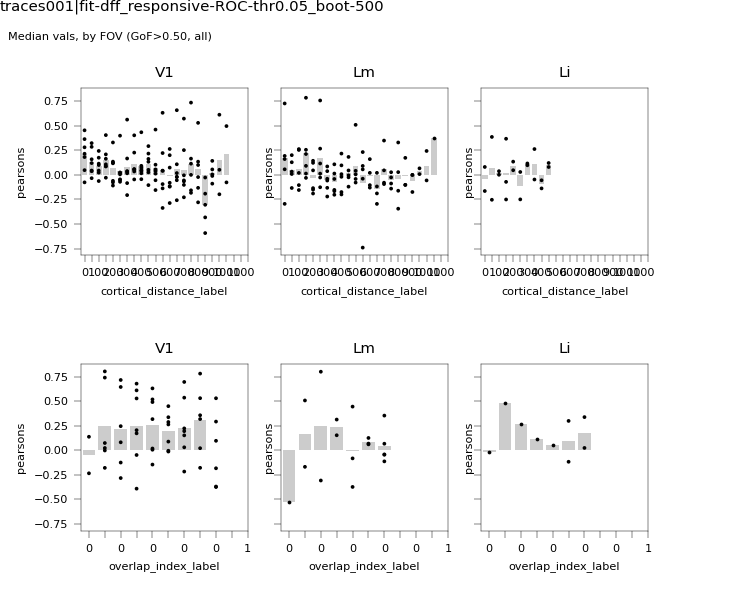

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta barplot_medFOV_pearsons_v_dist-metrics_all


In [98]:
# Split distances into X um bins
df, dist_lut = cr.get_bins_and_cut(DISTS, ctx_step=50, overlap_step=0.1)

min_npairs=5
min_npoints=5
metric = 'pearsons'
#dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']
dist_vars=['cortical_distance', 'overlap_index']
# plot
fig, axn = pl.subplots(len(dist_vars),3, figsize=(6,5), dpi=150, 
                       sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    max_dist = df[dist_var].max()
    min_npairs=5
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]
    x_var = '%s_label' % dist_var
    count_groups = [x_var, 'datakey']
    for va, cc0 in df.groupby('visual_area'):
        ax=axn[ri, visual_areas.index(va)]
        cnts = cc0.groupby(count_groups)['neuron_pair'].count()  
        # How many resample per group
        nsamples_per = dict((k, v) for k, v \
                            in zip(cnts[cnts>=min_npairs].index.tolist(),
                                   cnts[cnts>=min_npairs].values))
        if len(nsamples_per)<min_npoints:
            ax.set_title('%s (too few cells)' % va)
            ax.set_box_aspect(1)
            continue
        # Sample
        cc_ = pd.concat([cg for c, cg in cc0.groupby(count_groups) \
                             if c in nsamples_per.keys()])
        by_fov = cc_.groupby(count_groups).median().reset_index()
        # Get counts
        cnt_df = cnts.reset_index().rename(columns={'neuron_pair': 'n_pairs'})
        cnts_and_vals = pd.merge(cnt_df[cnt_df['n_pairs']>=min_npairs], by_fov, 
                            on=count_groups, how='outer')
        sns.barplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax,color=[0.8]*3,
                   ci=None)
        sns.stripplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax,
                      size=2, color='k', alpha=1, jitter=False)
        ax.set_box_aspect(1)
        ax.set_title(va)

        x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]
        ax.set_xticks(np.arange(0, len(x_bins)))
        if dist_var=='area_overlap':
            ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
        else:
            ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, hspace=0.5)
fig.text(0.01, 0.94, 'Median vals, by FOV (GoF>%.2f, %s)' % (gof_thr, select_stimuli))

pplot.label_figure(fig, data_id)
figname = 'barplot_medFOV_%s_v_dist-metrics_%s' % (metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Boxplot, all pairs

<IPython.core.display.Javascript object>


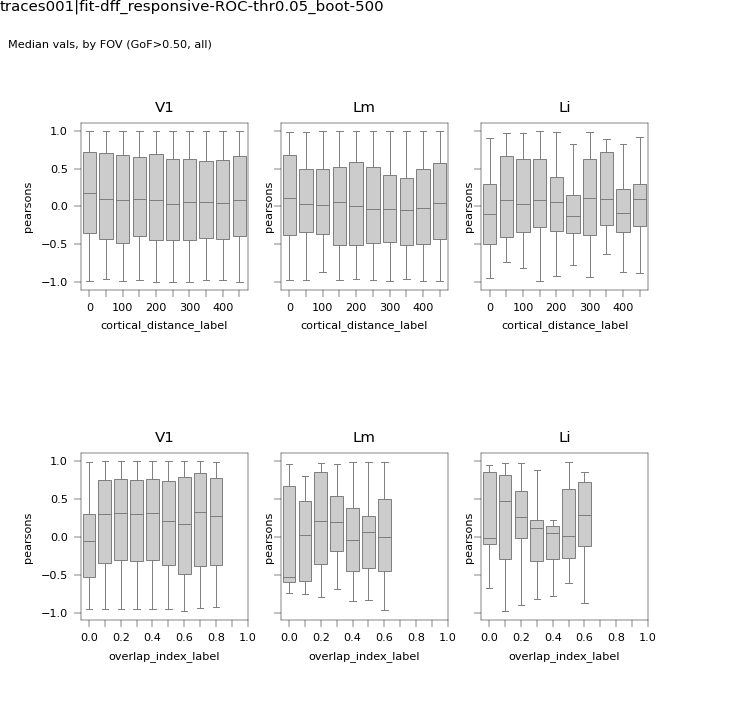

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta boxplot_pearsons_v_dist-metrics_allpairs_all


In [99]:
# Split distances into X um bins
ctx_maxdist=500
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=50, overlap_step=0.1)
min_npairs=5
min_npoints=5
metric = 'pearsons'
dist_vars=['cortical_distance', 'overlap_index']
# plot
fig, axn = pl.subplots(len(dist_vars), 3, figsize=(6,6), 
                       dpi=150, sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    max_dist = df[dist_var].max()
    min_npairs=5
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]
    x_var = '%s_label' % dist_var
    count_groups = [x_var, 'datakey']
    for va, cc0 in df.groupby('visual_area'):
        ax=axn[ri, visual_areas.index(va)]
        cnts = cc0.groupby(count_groups)['neuron_pair'].count()  
        # How many resample per group
        nsamples_per = dict((k, v) for k, v \
                            in zip(cnts[cnts>=min_npairs].index.tolist(),
                                   cnts[cnts>=min_npairs].values))
        if len(nsamples_per)<min_npoints:
            ax.set_title('%s (too few cells)' % va)
            ax.set_box_aspect(1)
            continue
        # Sample
        cc_ = pd.concat([cg for c, cg in cc0.groupby(count_groups) \
                             if c in nsamples_per.keys()])
        #by_fov = cc_.groupby(count_groups).median().reset_index()
        # Get counts
        #cnt_df = cnts.reset_index().rename(columns={'neuron_pair': 'n_pairs'})
        #cnts_and_vals = pd.merge(cnt_df[cnt_df['n_pairs']>=min_npairs], by_fov, 
        #                    on=count_groups, how='outer')
        sns.boxplot(x=x_var, y=metric, data=cc_, ax=ax, fliersize=0, 
                   linewidth=0.5, color=[0.8]*3)
#         sns.stripplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax,
#                       size=2, color='k', alpha=1)
        ax.set_box_aspect(1)
        ax.set_title(va)
        x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]
        ax.set_xticks(np.arange(0, len(x_bins)))
        if max_dist==1: #dist_var=='area_overlap':
            ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] \
                                else '' for i in x_bins])
        else:
            ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, hspace=0.5)
fig.text(0.01, 0.94, 'Median vals, by FOV (GoF>%.2f, %s)' % (gof_thr, select_stimuli))

pplot.label_figure(fig, data_id)
figname = 'boxplot_%s_v_dist-metrics_allpairs_%s' % (metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [101]:
import analyze2p.scatter as sct

In [102]:
yvs = df_['pearsons'].values
r_=[]
for dist_var in ['cortical_distance', 'rf_distance', 'overlap_index']:
    xvs=df_[dist_var].values
    regr_, _ = sct.do_linear_fit(xvs, yvs)
    regr_['distance_var'] = dist_var
    r_.append(regr_)

In [103]:
pd.concat(r_)

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,distance_var
0,0.000754,0.606218,0.137124,0.027451,0.000135,0.155833,cortical_distance
0,0.000072,0.606425,0.645491,-0.008496,-0.001336,0.202692,rf_distance
0,0.000057,0.606429,0.682454,-0.007556,-0.023766,0.207384,overlap_index


# Tuning curve similarity, test metrics

In [15]:
def cosine_similarity(v1, v2):
    return (v1.dot(v2)) / (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))


In [16]:
import analyze2p.gratings.bootstrap_osi as osi

In [17]:
from scipy import signal

In [18]:
params = ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']   

tested_thetas = np.arange(0, 360, 45)  
n_intervals=3
thetas = osi.interp_values(tested_thetas, n_intervals=n_intervals, wrap_value=360)  

In [19]:
# dists[dists['xcorr']>2]

In [119]:
# va='V1'
# dk='20190511_JC083_fov1'
# r1 = 27
# r2 = 107
# ----------------------
dk ='20190617_JC097_fov1'
va='V1'
# r1 = 203
# r2=399
r1 = 399
r2= 37 #361

fitdf = FITS[(FITS.visual_area==va) & (FITS.datakey==dk)].copy()
fitdf.index = fitdf['cell'].values
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# adist = dists[(dists.visual_area==va) & (dists.datakey==dk)].copy()

In [120]:
# fig, axn = pl.subplots(1,2)
# ax=axn[0]
# sns.regplot(x='cortical_distance', y='xcorr', data=adist, ax=ax)
# ax=axn[1]
# sns.regplot(x='cortical_distance', y='pearsons', data=adist, ax=ax)

In [121]:
# testd = adist[adist['xcorr']>=2]
# np.union1d(testd['cell_1'].values, testd['cell_2'].values)
# r1=27
# r2 = 107

<IPython.core.display.Javascript object>


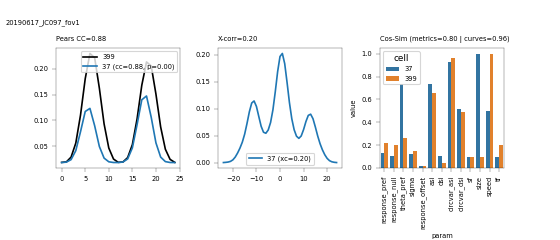

Text(0.01, 0.9, '20190617_JC097_fov1')

In [122]:
%matplotlib notebook
#r1 =27
# r2 = 116
#r2 = 281

popt_r1 = fitdf[params].loc[r1]
fitr1 = osi.double_gaussian(thetas, *popt_r1)

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(fitr1, label=r1, color='k')

for r2 in [ r2]: #[37, 361, 203]:
    popt_r2 = fitdf[params].loc[r2]
    fitr2 = osi.double_gaussian(thetas, *popt_r2)

    ccorr = signal.correlate(fitr1, fitr2)
    lags = signal.correlation_lags(len(fitr1), len(fitr2))
    cc, pv = spstats.pearsonr(fitr1, fitr2)
    
    axn[0].plot(fitr2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv))
    axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=6)

    #ax.legend()
    lagzero = list(lags).index(0)
    xcorr = ccorr[lagzero]

    axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr))
    axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=6)
    #axn[1].set_ylim([0, 1])

axn[0].legend()
axn[1].legend()

ax=axn[2]
cosim_c = cosine_similarity(fitr1, fitr2)
d0, cosim_m = get_paired_tuning_metrics(fitdf, r1, r2)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=6)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

In [25]:
cosine_similarity(fitr1, fitr2)

0.9261705840406864

In [116]:
def get_paired_tuning_metrics(fitdf, r1, r2):
    tuning_params = ['response_pref', 'response_null', 'theta_pref', 'sigma',
                     'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 
                     'sf', 'size', 'speed', 'tf']
    d_=[]
    for ri in [r1, r2]:
        d1 = pd.DataFrame({'param': fitdf.loc[ri][tuning_params].index.tolist(),
                            'value': fitdf.loc[ri][tuning_params].values})
        d1['cell'] = ri
        d_.append(d1)
    d0 = pd.concat(d_, axis=0)
    cosim_m1 = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    # normalize values
    d0.loc[d0.param=='size', 'value'] = d0[d0.param=='size']['value'] /200. 
    d0.loc[d0.param=='speed', 'value'] = d0[d0.param=='speed']['value'] /20. 
    d0.loc[d0.param=='theta_pref', 'value'] = d0[d0.param=='theta_pref']['value'] /360. 
    d0.loc[d0.param=='sigma', 'value'] = d0[d0.param=='sigma']['value'] /180. 
    d0.loc[d0.param=='tf', 'value'] = d0[d0.param=='tf']['value'] /10. 

    cosim_m = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    return d0, cosim_m
    #print(cosim_m1, cosim_m)

In [102]:
get_paired_tuning_metrics(fitdf, r1, r2)

0.9857650412181227 0.8582520592249347


In [84]:
fitdf.loc[r1][tuning_params].index

Index(['response_pref', 'response_null', 'theta_pref', 'sigma',
       'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf',
       'size', 'speed', 'tf'],
      dtype='object')

<IPython.core.display.Javascript object>


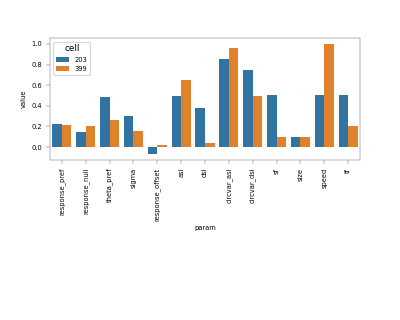

In [95]:
fig, ax = pl.subplots()
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)

In [56]:
cosine_similarity(fitdf.loc[r1][tuning_params], fitdf.loc[r2][tuning_params])


0.9541915669366513

## debug fits

In [113]:
pars = ['gof','sigma', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf', 'size', 'speed']

gdata[(gdata.datakey==dk) & (gdata['cell']==107)][pars]

,gof,sigma,asi,dsi,circvar_asi,circvar_dsi,sf,size,speed
2567,0.612545,23.429372,0.723484,0.21754,0.896353,0.690266,0.1,200.0,20.0


In [115]:
fitres, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc)


In [118]:
rid = 107
fitres[rid]

{(0.1,
  20.0,
  20): {'results':      response_pref  response_null  theta_pref      sigma  response_offset  \
  0         0.319591       0.224039  275.030744  22.500000         0.250420   
  1         0.251892       0.214297  102.173855  31.469004         0.209163   
  2         0.252955       0.234488   97.092914  26.704377         0.247924   
  3         0.278421       0.165424  104.683387  35.264606         0.197618   
  4         0.261811       0.218827  275.411303  22.500000         0.256697   
  ..             ...            ...         ...        ...              ...   
  495       0.316770       0.251721  110.284715  48.225670         0.055361   
  496       0.229872       0.227676  277.341329  22.500000         0.240974   
  497       0.412286       0.231973  101.613582  51.640699         0.076976   
  498       0.290760       0.252948  273.011817  22.500000         0.228227   
  499       0.235201       0.203375   93.805015  22.590270         0.221040   
  
            asi  

In [121]:
fitres[rid].keys()

dict_keys([(0.1, 20.0, 20), (0.1, 40.0, 20), (0.1, 200.0, 20), (0.5, 20.0, 20), (0.5, 200.0, 20)])

In [122]:
rmetrics, rmetrics_all_cfgs = gutils.get_good_fits(fitres, fitparams, gof_thr=None)


... 97 (of 103) fitable cells (no GoF thr)


In [124]:
rmetrics_all_cfgs[rmetrics_all_cfgs['cell']==rid]

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,cell,r2comb,gof,sf,size,speed
sf-0.10-sz-200-sp-20,0.504464,0.318016,271.836735,23.429372,0.145669,0.723484,0.21754,0.896353,0.690266,0.904699,107,0.534968,0.612545,0.1,200.0,20.0


In [125]:
for stimparam, bootr in fitres[rid].items():
    #r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=3)
    #print(stimparam, gof)

(0.1, 20.0, 20) nan
(0.1, 40.0, 20) nan
(0.1, 200.0, 20) 0.6125448933397163
(0.5, 20.0, 20) nan
(0.5, 200.0, 20) nan


In [130]:
eparams = [c for c in bootr['results'].columns if 'stim' not in c]
print(eparams)


['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'r2', 'cell']


In [152]:
fit_params= ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']
             
for stimparam, bootr in fitres[rid].items():
    
    fitdf = bootr['results'][eparams]
#     for param in fitdf.columns:
#         if 'theta' in param:
#             cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
#             meanval = float(bns[np.where(cnts==max(cnts))[0][0]])  
#         else:
#             meanval = fitdf[param].mean()
#         print(param, meanval)
    avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
    #print(stimparam, avg_metrics)
    orig_ = bootr['data']['responses'].mean(axis=0).copy()
    if orig_.min()<0:
        print(stimparam, 'neg.')
        orig_ -= orig_.min()
    origr = gutils.interp_values(orig_)   
    thetas = bootr['fits']['xv']
    cpopt = tuple(avg_metrics[fit_params].values[0])
    fitr = gutils.double_gaussian( thetas, *cpopt) 
    r2_comb, _ = gutils.coeff_determination(origr, fitr)
    iqr = spstats.iqr(bootr['results']['r2'])          
    gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 
    print(stimparam, gfit)

0.1968532985056689
(0.1, 20.0, 20) 0.4967150432314194
0.09582170304881409
(0.1, 40.0, 20) 0.836783415282605
0.09684316594010572
(0.1, 200.0, 20) 0.8047953761626189
0.3399764977173693
(0.5, 20.0, 20) nan
0.14527391384274382
(0.5, 200.0, 20) 0.270802526259742


In [160]:
stimparam = (0.5, 20.0, 20)
bootr = fitres[rid][stimparam]
avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
orig_ = bootr['data']['responses'].mean(axis=0).copy()
origr = gutils.interp_values(orig_)   
thetas = bootr['fits']['xv']
cpopt = tuple(avg_metrics[fit_params].values[0])
fitr = gutils.double_gaussian( thetas, *cpopt) 
r2_comb, _ = gutils.coeff_determination(origr, fitr)

In [162]:
iqr = spstats.iqr(bootr['results']['r2'])          
gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 

In [165]:
np.mean(bootr['results']['r2'])

0.8003723260982941

In [166]:
(1-iqr)

0.8565975455384629

In [169]:
dk

'20190511_JC083_fov1'

<IPython.core.display.Javascript object>


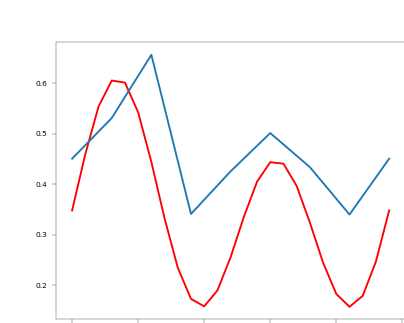

In [161]:
fig, ax = pl.subplots()
ax.plot(fitr, 'r')
ax.plot(origr)

In [151]:
bootr['data']['responses'].mean(axis=0).min()

0.14527391384274382

In [136]:
cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
float(bns[np.where(cnts==max(cnts))[0][0]])  

249.79591836734696